In [1]:
import numpy as np
import psi4
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import random
from IPython.display import HTML

In [2]:

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Show/Hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [3]:
def X_matrix(S):
    evalues,U= np.linalg.eigh(S) #S=U*evalues*Udagger
    s=np.diag(1/np.sqrt(evalues))#matrice diagonale avec l'inverse des racines des valeurs propres

    X=np.matmul(np.matmul(U,s),np.conjugate(U.T)) #X=Us^(-1/2)U*
    #X=np.matmul(U,s) #X=Us^(-1/2)
    
    if verif_X_matrix(X,S):
        return(X)
    else: 
        print('problem with X')
        return

def verif_X_matrix(X,S):
    Xh=np.conjugate(X.T)
    n=len(X)
    verif=np.matmul(Xh,np.matmul(S,X))
    if (abs(verif-np.identity(n))<(10**-10)).all():
        return True
    else:
        return(False)
hide_toggle()

In [4]:
#Calcul de F a l'aide de la matrice densité F= H + G
def G_matrix(P,v):
    n=len(P)
    G=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    G[i,j]+=P[k,l]*(v[i][j][k][l]-0.5*v[i][l][k][j])
    return(G)
#  
#fonction calcul  F'=X*FX

def new_fock_matrix(F,X):
    FX=np.matmul(F,X)
    return(np.matmul(np.conjugate(X.T),FX))
##
hide_toggle()

In [5]:
#calcul matrice C=XC' des coefs

def coef_matrix(f,X):
    energy,c = np.linalg.eigh(f)
    C = np.matmul(X,c)
    return(C)
hide_toggle()

In [6]:
def new_density_matrix(C,Bas_n,N):
    P=np.zeros_like(C)
    for i in range(Bas_n):
        for j in range(Bas_n):
            for a in range(int(N/2)):
                P[i,j]+=2*C[i,a]*C[j,a]
    return(P)
hide_toggle()

In [7]:
#convergence de l'algo avec le commutateur

def convergence(F,P,S,lim):
    FPS=np.matmul(F,np.matmul(P,S))
    SPF=np.matmul(S,np.matmul(P,F))
    if (abs(FPS-SPF)<=lim).all():
        return True
    else:
        return False
    
hide_toggle()
    

In [8]:
def SCF_energy(S,v,H,Bas_n,N,lim,max_iter,mol):
    #initialisation
    X=X_matrix(S)
    P=np.zeros((Bas_n,Bas_n))

    New_Energy=0
    Old_Energy=0
    
    Enn=mol.nuclear_repulsion_energy()
    
    #Boucle convergence
    F=H
    for n_iter in range(max_iter):


        
        #Calcul de la nouvelle matrice densité
        f=new_fock_matrix(F,X)
        C=coef_matrix(f,X)
        P=new_density_matrix(C,Bas_n,N)
        
        #Matrice de Fock
        G=G_matrix(P,v)
        F=H+G
        
        #Calcul de l'énergie
        Old_Energy=New_Energy 
        New_Energy=0.5*np.trace(np.matmul(P,H+F))
        
        #Condition de convergence
        
        if n_iter!=0 and (abs(New_Energy-Old_Energy)<lim):
            #print('Converged after', n_iter,'iterations')
            #print(np.matmul(np.linalg.inv(C),np.matmul(F,C)))
            return(New_Energy+Enn,C,P,F)
    print('Did not converge')
    return(New_Energy+Enn,C,P,F)

hide_toggle()

In [31]:
def Diatomic_Energy(Dist,at1,at2,Basis_set):
# géométrie de la molécule
    mol = psi4.geometry("""
    """+at1+"""  0.0 0.0 0.0 
    """+at2+"""  0.0 """+str(Dist)+""" 0.0

    """)
    

    geo_unit = psi4.core.GeometryUnits(0) # Angstrom:0 , bohr:1
    null=psi4.core.Molecule.set_units(mol,geo_unit)
    null=psi4.core.Molecule.set_molecular_charge(mol,0)
    null=psi4.core.Molecule.set_multiplicity(mol,1)
    
    #Fonction d'onde de la molécule
    wf = psi4.core.Wavefunction.build(mol,basis=Basis_set)
    mints = psi4.core.MintsHelper(wf.basisset())

    #différentes intégrales calculées par psi4
    S = np.asarray(mints.ao_overlap())
    v = np.asarray(mints.ao_eri())
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H=T+V
    
    #Différents paramètres pour l'algo
    Bas_n = S.shape[0] #shape(H)=(Bas_n,Bas_n)
    N= int(2*wf.nalpha())
    lim=10**(-10)
    max_iter=100
    #calcul des énergies en Ha

    HF_energy,C,P,F=SCF_energy(S,v,H,Bas_n,N,lim,max_iter,mol)
    MP2_energy=HF_energy - MP_Energy(v,C,H,N,P,F)
    print('dif=',abs(MP2_energy-psi4.energy('mp2/'+Basis_set+'') ))
    return(MP2_energy)
    #return(psi4.energy('mp2/'+Basis_set+''))

hide_toggle()

In [10]:
def water(Theta,Dist):
    mol = psi4.geometry("""
    O  0.0  0.0  0.0
    H  """+str(Dist)+"""  0.0  0.0
    H  """+str(Dist*np.cos(Theta))+"""  """+str(Dist*np.sin(Theta))+"""  0.0

    """)

    
    geo_unit = psi4.core.GeometryUnits(0) # Angstrom:0 , bohr:1
    null=psi4.core.Molecule.set_units(mol,geo_unit)
    null=psi4.core.Molecule.set_molecular_charge(mol,0)
    null=psi4.core.Molecule.set_multiplicity(mol,1)
  


    #Fonction d'onde de la molécule
    wf = psi4.core.Wavefunction.build(mol,basis='sto-3g')
    mints = psi4.core.MintsHelper(wf.basisset())

    #différentes intégrales calculées par psi4
    S = np.asarray(mints.ao_overlap())
    v = np.asarray(mints.ao_eri())
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H=T+V
    
    #Différents paramètres pour l'algo
    Bas_n = S.shape[0] #shape(H)=(Bas_n,Bas_n)
    N= int(2*wf.nalpha())
    lim=10**(-12)
    max_iter=100
    #calcul des énergies en Ha

    HF_energy,C,P,F=SCF_energy(S,v,H,Bas_n,N,lim,max_iter,mol)
    MP2_energy=HF_energy - MP_Energy(v,C,H,N,P,F)
    return(MP2_energy)
    #return(SCF_energy(S,v,H,Bas_n,N,lim,max_iter,mol))
hide_toggle()

In [32]:
def Two_e_int_MO(v,C):
    #INLS=np.einsum('mi,mnls->imls',C,v)
    #IJLS=np.einsum('nj,inls->ijls',C,INLS)
    #IJKS=np.einsum('lk,ijls->ijks',C,IJLS)
    #IJKL=np.einsum('sl,ijks->ijkl',C,IJKS)
    #return(IJKL)
    return(np.einsum("uvkl, up, vq, kr, ls -> pqrs", v, C,C, C, C))

def FMatrix_OM2(H,v_OM,C,P):
    C_conj=np.conjugate(C)
    H_OM=np.einsum('im,jn,mn->ij',C_conj,C,H)
    G_OM=G_matrix(P,v_OM) #P 2*np.identity(np.shape(P)[1])
    
    F_OM=H_OM+G_OM
    return(F_OM)

def FMatrix_OM(F,C):
    return(np.matmul(np.linalg.inv(C),np.matmul(F,C)))


def MP_Energy(v,C,H,N,P,F):
    n_OM=int(np.shape(C)[1])
    v_OM=Two_e_int_MO(v,C)
    MP=0
    F_OM=FMatrix_OM(F,C)
    #F_OM=FMatrix_OM2(H,v_OM,C,P)
    En_OM=np.einsum('ii->i',F_OM)
    #En_OM=np.linalg.eigh(F_OM)[0]
    for a in range(int(N/2)):
        for b in range(int(N/2)):
            for r in range(int(N/2),n_OM):
                for s in range(int(N/2),n_OM):
                    MP+=(v_OM[a,b,r,s]*(2*v_OM[r,s,a,b]-v_OM[r,s,b,a]))/(En_OM[r]+En_OM[s]-En_OM[a]-En_OM[b])
    return(MP)                 

In [33]:
psi4.set_memory('500 MB')
#liste de distance et listes pour les énergies
Dist_list=np.linspace(0.1,8,num=50)
Energy_list=[]

for Dist in Dist_list:
    psi4.core.clean()
    Energy_list.append(Diatomic_Energy(Dist,'H','H','cc-pvdz'))
    print(Dist)

dif= 0.6967580847257338
0.1
dif= 0.6650247582188077
0.2612244897959184
dif= 0.6267491680417804
0.4224489795918368
dif= 0.5850220442045351
0.5836734693877551
dif= 0.5488535799579848
0.7448979591836735
dif= 0.5253013800697204
0.9061224489795919
dif= 0.5089956125839112
1.0673469387755103
dif= 0.4966083444861964
1.2285714285714289
dif= 0.48697040646110734
1.3897959183673472
dif= 0.479363134861585
1.5510204081632655
dif= 0.4732293850579046
1.712244897959184
dif= 0.4682294359727134
1.8734693877551023
dif= 0.4643273671379793
2.0346938775510206
dif= 0.461489139301939
2.195918367346939
dif= 0.4595041861508018
2.3571428571428577
dif= 0.45809409149605296
2.518367346938776
dif= 0.4570008952504735
2.6795918367346943
dif= 0.45601186087006784
2.8408163265306126
dif= 0.4549616764967649
3.002040816326531
dif= 0.45372625378878695
3.1632653061224496
dif= 0.4522117883522757
3.324489795918368
dif= 0.45034507211808916
3.485714285714286
dif= 0.4480692964207562
3.6469387755102045
dif= 0.44534474342625874
3.80

[ 1.94505126 -1.09026449 -1.60430634 -1.71056353 -1.70399827 -1.66865099
 -1.62589457 -1.58314206 -1.54373693 -1.50882888 -1.47862461 -1.45304615
 -1.43203207 -1.41536489 -1.40259286 -1.39319093 -1.38666342 -1.38256806
 -1.38051527 -1.38016028 -1.38119156 -1.38332162 -1.38628496 -1.38984259
 -1.39378991 -1.39795951 -1.4022273  -1.40650739 -1.41074766 -1.41492299
 -1.41902822 -1.42307178 -1.42707028 -1.43104446 -1.43501612 -1.43900612
 -1.44303312 -1.44711285 -1.45125791 -1.45547777 -1.45977904 -1.46416579
 -1.46863995 -1.47320176 -1.47785009 -1.48258283 -1.4873972  -1.49228996
 -1.31558489 -1.32625642]


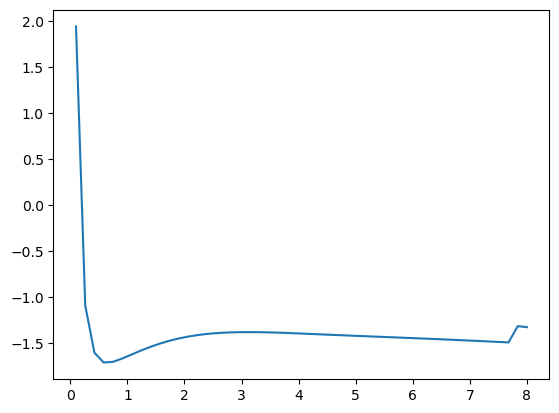

In [35]:
plt.plot(Dist_list,np.asarray(Energy_list))
print(np.asarray(Energy_list))